<a href="https://colab.research.google.com/github/shnhrtkyk/JTCcode/blob/main/05_%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AB%E3%82%88%E3%82%8B%E7%82%B9%E7%BE%A4%E3%81%AE%E3%82%BB%E3%83%9E%E3%83%B3%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF%E3%82%BB%E3%82%B0%E3%83%A1%E3%83%B3%E3%83%86%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# セマンティックセグメンテーションの実装

セマンティックセグメンテーションとは、入力された各点にクラス情報を付与する手法です。
セマンティックセグメンテーションにより、入力された点群がどのような環境なのか、具体的には道路の上に車があるなどの環境認識を3次元空間で行うことができます。

# 必要なライブラリをインストール

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.0+cu118


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 27.9 MB/s eta 0:00:00


## ライブラリのインポート

In [3]:
import os
import random
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F

from torch_scatter import scatter
from torchmetrics.classification import MulticlassJaccardIndex

import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, DynamicEdgeConv

## 初期化

In [4]:
config_seed = 42
config_device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(config_seed)
torch.manual_seed(config_seed)
device = torch.device(config_device)

# 対象のクラスを選ぶ、今回はギターのセグメンテーションをします。
config_category = "Guitar" # ["Bag", "Cap", "Car", "Chair", "Earphone", "Guitar", "Knife", "Lamp", "Laptop", "Motorbike", "Mug", "Pistol", "Rocket", "Skateboard", "Table"] 
config_random_jitter_translation = 1e-2
config_random_rotation_interval_x = 15
config_random_rotation_interval_y = 15
config_random_rotation_interval_z = 15
config_validation_split = 0.2
config_batch_size = 16
config_num_workers = 6

config_num_nearest_neighbours = 30
config_aggregation_operator = "max"
config_dropout = 0.5
config_initial_lr = 1e-3
config_lr_scheduler_step_size = 5
config_gamma = 0.8
# エポック数は1回です
config_epochs = 1

# ShapeNetというデータセットを読み込む

ShapeNetという、物体のパーツごとにクラスが付与されたデータセットを用います。
※ダウンロードに時間がかかります。

In [5]:
transform = T.Compose([
    T.RandomJitter(config_random_jitter_translation),
    T.RandomRotate(config_random_rotation_interval_x, axis=0),
    T.RandomRotate(config_random_rotation_interval_y, axis=1),
    T.RandomRotate(config_random_rotation_interval_z, axis=2)
])
pre_transform = T.NormalizeScale()

In [6]:
dataset_path = os.path.join('ShapeNet', config_category)

train_val_dataset = ShapeNet(
    dataset_path, config_category, split='trainval',
    transform=transform, pre_transform=pre_transform
)

Extracting ShapeNet/Guitar/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


セグメンテーションデータの前処理

In [7]:
segmentation_class_frequency = {}
for idx in tqdm(range(len(train_val_dataset))):
    pc_viz = train_val_dataset[idx].pos.numpy().tolist()
    segmentation_label = train_val_dataset[idx].y.numpy().tolist()
    for label in set(segmentation_label):
        segmentation_class_frequency[label] = segmentation_label.count(label)
class_offset = min(list(segmentation_class_frequency.keys()))
print("Class Offset:", class_offset)

for idx in range(len(train_val_dataset)):
    train_val_dataset[idx].y -= class_offset

  0%|          | 0/628 [00:00<?, ?it/s]

Class Offset: 19


訓練データと検証データへの切り分け

In [8]:
num_train_examples = int((1 - config_validation_split) * len(train_val_dataset))
train_dataset = train_val_dataset[:num_train_examples]
val_dataset = train_val_dataset[num_train_examples:]

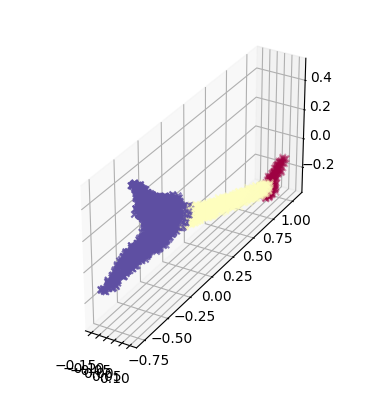

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

predicted_pc_viz = train_dataset[1].pos
label = train_dataset[1].y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(predicted_pc_viz[:, 0],   # x
          predicted_pc_viz[:, 1],   # y
          predicted_pc_viz[:, 2],   # z
          c=label[:], # height data for color
          cmap='Spectral',
          marker="x")
ax.axis('scaled')  # {equal, scaled}
plt.show()

今回のタスクは、物体のパーツ単位のセグメンテーションです。
したがって、今回のセグメンテーション対象であるギターの各パーツである、ヘッド・ネック・ボディに分かれています。

データローダーの設定

In [10]:
train_loader = DataLoader(
    train_dataset, batch_size=config_batch_size,
    shuffle=True, num_workers=config_num_workers
)
val_loader = DataLoader(
    val_dataset, batch_size=config_batch_size,
    shuffle=False, num_workers=config_num_workers
)
visualization_loader = DataLoader(
    val_dataset[:10], batch_size=1,
    shuffle=False, num_workers=config_num_workers
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# PyTorch Geometricによる実装

今回はDGCNNという点群の深層学習手法を実装します。
DGCNNはDynamic Graph CNNという手法で、各点に対して特徴量空間のKNNで周辺の点を検索し、そのKNNの点に対してDynamicEdgeConvを適用します。



層の構造は、各点に対して`DynamicEdgeConv`を適用します。
このDynamicEdgeConvを3回くりかえして、周辺点の情報を集約していきます。
その後、最終層で各点ごとにクラス分類を行います。
クラス分類には、単純なＭＬＰを適用し、出力次元数は分類したいクラス数と同じにします。
この実装では、返り値を計算する際に、`F.log_softmax`を適用します。

In [11]:
class DGCNN(torch.nn.Module):
    def __init__(self, out_channels, k=30, aggr='max'):
        super().__init__()

        self.conv1 = DynamicEdgeConv(MLP([2 * 6, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)
        self.conv3 = DynamicEdgeConv(MLP([2 * 64, 64, 64]), k, aggr)

        self.mlp = MLP(
            [3 * 64, 1024, 256, 128, out_channels],
            dropout=0.5, norm=None
        )

    def forward(self, data):
        x, pos, batch = data.x, data.pos, data.batch
        x0 = torch.cat([x, pos], dim=-1)
        
        x1 = self.conv1(x0, batch)
        x2 = self.conv2(x1, batch)
        x3 = self.conv3(x2, batch)
        
        out = self.mlp(torch.cat([x1, x2, x3], dim=1))
        return F.log_softmax(out, dim=1)

モデルの呼び出し

In [12]:
config_num_classes = train_dataset.num_classes
print(config_num_classes)
model = DGCNN(
    out_channels=train_dataset.num_classes,
    k=config_num_nearest_neighbours,
    aggr=config_aggregation_operator
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config_initial_lr)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=config_lr_scheduler_step_size, gamma=config_gamma
)

50


# 訓練の実装

In [13]:
def train_step(epoch):
    model.train()
    
    ious, categories = [], []
    total_loss = correct_nodes = total_nodes = 0
    y_map = torch.empty(
        train_loader.dataset.num_classes, device=device
    ).long()
    num_train_examples = len(train_loader)
    
    progress_bar = tqdm(
        train_loader, desc=f"Training Epoch {epoch}/{config_epochs}"
    )
    
    for data in progress_bar:
        data = data.to(device)
        
        optimizer.zero_grad()
        outs = model(data)
        loss = F.nll_loss(outs, data.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        correct_nodes += outs.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes
        
        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(ShapeNet.seg_classes.keys())[category]
            part = ShapeNet.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            jaccard_index = MulticlassJaccardIndex(num_classes=part.size(0)).to(device)

            iou = jaccard_index(
                out[:, part].argmax(dim=-1), y_map[y]
            )
            ious.append(iou)

        categories.append(data.category)
        
    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)
    mean_iou = float(scatter(iou, category, reduce='mean').mean())
    
    return {
        "Train/Loss": total_loss / num_train_examples,
        "Train/Accuracy": correct_nodes / total_nodes,
        "Train/IoU": mean_iou
    }

In [14]:
@torch.no_grad()
def val_step(epoch):
    model.eval()

    ious, categories = [], []
    total_loss = correct_nodes = total_nodes = 0
    y_map = torch.empty(
        val_loader.dataset.num_classes, device=device
    ).long()
    num_val_examples = len(val_loader)
    
    progress_bar = tqdm(
        val_loader, desc=f"Validating Epoch {epoch}/{config_epochs}"
    )
    
    for data in progress_bar:
        data = data.to(device)
        outs = model(data)
        
        loss = F.nll_loss(outs, data.y)
        total_loss += loss.item()
        
        correct_nodes += outs.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(ShapeNet.seg_classes.keys())[category]
            part = ShapeNet.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)
            jaccard_index = MulticlassJaccardIndex(num_classes=part.size(0)).to(device)

            iou = jaccard_index(
                out[:, part].argmax(dim=-1), y_map[y]
            )
            ious.append(iou)

        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)
    mean_iou = float(scatter(iou, category, reduce='mean').mean())
    
    return {
        "Validation/Loss": total_loss / num_val_examples,
        "Validation/Accuracy": correct_nodes / total_nodes,
        "Validation/IoU": mean_iou
    }

結果を取得する関数

In [15]:
@torch.no_grad()
def visualization_step(epoch):
    model.eval()
    for data in tqdm(visualization_loader):
        data = data.to(device)
        outs = model(data)

        predicted_labels = outs.argmax(dim=1)
        accuracy = predicted_labels.eq(data.y).sum().item() / data.num_nodes

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        ious, categories = [], []
        y_map = torch.empty(
            visualization_loader.dataset.num_classes, device=device
        ).long()
        for out, y, category in zip(
            outs.split(sizes), data.y.split(sizes), data.category.tolist()
        ):
            category = list(ShapeNet.seg_classes.keys())[category]
            part = ShapeNet.seg_classes[category]
            part = torch.tensor(part, device=device)
            y_map[part] = torch.arange(part.size(0), device=device)
            jaccard_index = MulticlassJaccardIndex(num_classes=part.size(0)).to(device)
            iou = jaccard_index(
                out[:, part].argmax(dim=-1), y_map[y]
            )
            ious.append(iou)
        categories.append(data.category)
        iou = torch.tensor(ious, device=device)
        category = torch.cat(categories, dim=0)
        mean_iou = float(scatter(iou, category, reduce='mean').mean())

        gt_pc_viz = data.pos.cpu().numpy().tolist()
        segmentation_label = data.y.cpu().numpy().tolist()
        predicted_labels =  predicted_labels.cpu().numpy().tolist()
        frequency_dict = {key: 0 for key in segmentation_class_frequency.keys()}
        for label in set(segmentation_label):
            frequency_dict[label] = segmentation_label.count(label)
        for j in range(len(gt_pc_viz)):
            # gt_pc_viz[j] += [segmentation_label[j] + 1 - class_offset]
            gt_pc_viz[j] += [segmentation_label[j] + 1]

        predicted_pc_viz = data.pos.cpu().numpy().tolist()
        segmentation_label = data.y.cpu().numpy().tolist()
        frequency_dict = {key: 0 for key in segmentation_class_frequency.keys()}
        for label in set(segmentation_label):
            frequency_dict[label] = segmentation_label.count(label)
        for j in range(len(predicted_pc_viz)):
            # predicted_pc_viz[j] += [segmentation_label[j] + 1 - class_offset]
            predicted_pc_viz[j] += [predicted_labels[j] + 1]

    
    return predicted_pc_viz

In [16]:
def save_checkpoint(epoch):
    """Save model checkpoints as Weights & Biases artifacts"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, "checkpoint.pt")
    


実際の訓練を回してみましょう。
今回は1エポックですが、`config_epochs`の値を大きくすると学習する回数が多くなります。

  0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Epoch 1/1:   0%|          | 0/8 [00:00<?, ?it/s]

{'Train/Loss': 0.2855552597902715, 'Train/Accuracy': 0.8858671456099727, 'Train/IoU': 0.49280500411987305, 'Validation/Loss': 0.22936853021383286, 'Validation/Accuracy': 0.9104818794633919, 'Validation/IoU': 0.5363754034042358}


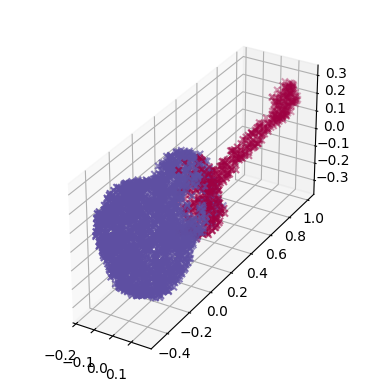

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for epoch in range(1, config_epochs + 1):
    predicted_pc_viz = visualization_step(epoch)
    predicted_pc_viz = np.array(predicted_pc_viz)




    train_metrics = train_step(epoch)
    val_metrics = val_step(epoch)
    
    metrics = {**train_metrics, **val_metrics}
    print(metrics)
    metrics["learning_rate"] = scheduler.get_last_lr()[-1]


    
    scheduler.step()
    save_checkpoint(epoch)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(predicted_pc_viz[:, 0],   # x
              predicted_pc_viz[:, 1],   # y
              predicted_pc_viz[:, 2],   # z
              c=predicted_pc_viz[:, 3], # height data for color
              cmap='Spectral',
              marker="x")
    ax.axis('scaled')  # {equal, scaled}
    plt.show()


学習回数が1エポックなので、あまり学習が進んでおわず、パーツ単位のセグメンテーションがうまくいっていないことがわかると思います。今回の講義では、時間の制約で1エポックとしていますが、エポック数を長く設定するともう少しセグメンテーションの結果が良くなります。